- 1. hvor lange tid tage det og ankomme til destination


- 2. Hvor lange tid tage det i genmesnigt for en fire case


- 3. Zipcode Battalion station area


- 4. Suppression Units and Personnel


- 5. Primary Situation


- 6. Action Taken Primary


- 7. Action Taken Primary


- 8. neighborhood_district


- 9. Point for maps


In [1]:
import pandas as pd
df = pd.read_csv("../Fire_Incidents.csv")
df['Incident Date'] = pd.to_datetime(df['Incident Date'])

# Get the data from date 2010-04-01 to 2023-04-01
df = df[(df['Incident Date'] >= '2010-04-01') &
        (df['Incident Date'] <= '2023-04-01')]
df['Incident Time'] = df['Incident Date'].dt.time

df['Incident year'] = df['Incident Date'].dt.year
# print the number of rows
num_rows = df.shape[0]
print("The number of rows is:", num_rows)
#print(df.head())


C:\Users\salim\AppData\Local\Temp\ipykernel_8656\790445525.py:2: DtypeWarning: Columns (10,12,13,20,38,45,46,55,59) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Fire_Incidents.csv")


The number of rows is: 409936


In [2]:
# get just the data from Sf city
df = df[(df['City'] == 'SF') | (df['City'] == 'San Francisco')
        | (df['City'] == 'SAN FRANCISCO')]

# Deleting all unnaseccary columns
df.drop(columns=['Automatic Extinguishing System Present', 'Automatic Extinguishing Sytem Type', 'Automatic Extinguishing Sytem Perfomance',
        'Automatic Extinguishing Sytem Failure Reason', 'Number of Sprinkler Heads Operating',
        'Detectors Present','Detector Type','Detector Operation','Detector Effectiveness','Detector Failure Reason'], inplace=True)


In [3]:
df['Primary Situation'].replace(['745 Alarm system sounded/no fire-accidental','735 Alarm system sounded due to malfunction'], '745 Alarm system activation', inplace=True)


df = df[df['Primary Situation'] != '554 Assist invalid']


# add Situation_by_code
df['focuse_Situation_by_number'] = df['Primary Situation'].str[:3]
#df.head(100)

## Finding Top 10 Situations calls

In [4]:
df['Primary Situation'] = df['Primary Situation'].str.replace('- ', '')
df.dropna(subset=['Primary Situation'], inplace=True)
df['Primary Situation'] = df['Primary Situation'].dropna().apply(lambda x: x.split(',')[0])
#print(call_Situation)

call_Situation = df['Primary Situation']
len(call_Situation)
ListOfSituation = call_Situation.unique()
print(ListOfSituation)
# by using unique() fun we can se the diffrenet type of data

Situation_count = call_Situation.value_counts()

# Get the top 15 most frequent situations
top10 = Situation_count.nlargest(10)  
#print(top10)
#print(call_Situation)


['700 False alarm or false call'
 '324 Motor vehicle accident with no injuries.'
 '118 Trash or rubbish fire' '322 Vehicle accident with injuries'
 '711 Municipal alarm system' '113 Cooking fire' '511 Lock-out'
 '600 Good intent call' '551 Assist PD or other Govern. Agency'
 '745 Alarm system sounded/no fire-accidental'
 '735 Alarm system sounded due to malfunction'
 '550 Public service assistance'
 '622 No incident found on arrival/disp. addr.' '554 Assist invalid'
 '321 EMS excluding veh. accident w/injuries' '651 Smoke scare'
 '442 Overheated motor' '743 Smoke detector'
 '154 Dumpster/Outside trash receptacle fire'
 '323 Auto/Ped. Accident (Veh.)' '111 Building fire'
 '740 Unintentional alarm' '150 Outside rubbish fire'
 '911 Citizen complaint' '151 Outside rubbish'
 '611 Dispatched & canceled en route' '744 Detector activation'
 '641 Vicinity alarm (incid. another location)' '311 Medical assist'
 '440 Elec. wiring/equip. problem' '714 Central station'
 '715 Local alarm sys.' '555 D

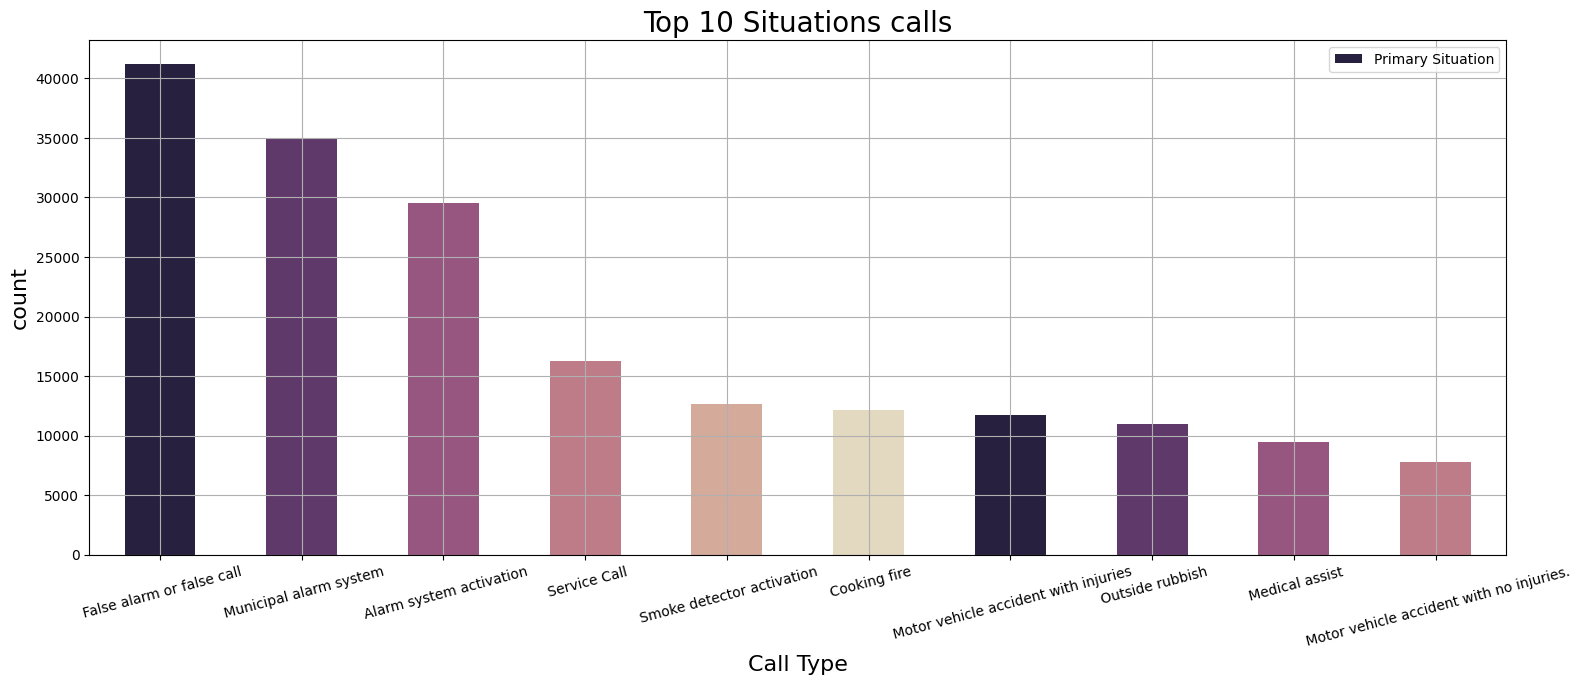

In [5]:
import matplotlib.pyplot as plt
import mplcursors 
import seaborn as sns

fig, ax = plt.subplots(figsize=(16, 7))

# define a color map
cmap = sns.color_palette("ch:s=-.2,r=.6")[::-1]

# plot the top 10 situations with the colormap
top10.plot(kind='bar', color=cmap, ax=ax)

# set the chart title and axis labels
plt.title('Top 10 Situations calls', fontsize=20)
plt.xlabel('Call Type', fontsize=16)
plt.ylabel('count', fontsize=16)

# add grid lines
ax.grid(True)

# adjust x-tick labels rotation and font size
plt.xticks(rotation=15, fontsize=10)
new_xticklabels = [label.get_text()[3:] for label in ax.get_xticklabels()]
ax.set_xticklabels(new_xticklabels)

# add legend
ax.legend(loc='upper right')

# add annotations
mplcursors.cursor(ax, hover=True).connect('add', lambda sel: sel.annotation.set_text(f"Situation: {sel.artist.get_label()}\nCalls: {sel.target.get_height()}"))

# adjust spacing
fig.tight_layout()

fig.subplots_adjust(bottom=0.2)
# display the chart


plt.show()


## Finding count of number of alarms in every neighborhood district

In [6]:
neighborhood = df['neighborhood_district']

ListOfneighborhood = neighborhood.dropna().unique()
#print(ListOfneighborhood)

#print("the len of neighborhood is: " ,len(ListOfneighborhood))
print("---------------------------------------------------------")
zipcode =df['zipcode'].str[:5]
ListOfzipcode = zipcode.dropna().unique()
#print(ListOfzipcode)
#print("the len of zipcode is: ", len(ListOfzipcode))


---------------------------------------------------------


We can se that the neighborhood and zipcode are too match value, and becouse of that I choosed to show the data with Battalion becouse we have at all 10 Battalions and that's better to understand

In [7]:
district = df['Battalion']
df = df[df['Battalion'] != 'B99']
ListOfdistrict = district.dropna().unique()
#print(ListOfdistrict)

print("the len of district is: " ,len(ListOfdistrict))
#df.head()

the len of district is:  11


In [8]:
from bokeh.models import ColumnDataSource,Legend,Select
from bokeh.io import output_notebook, show
from bokeh.palettes import Category10
import seaborn as sns
from bokeh.plotting import figure, show
from bokeh.io import output_file

# to satart wuth we should get the top 10 call situations
#print(top10)

# get a list of the top 10
top10_situations = top10.index.tolist()
#print(top10_situations)
df = df[df['Primary Situation'].isin(top10_situations)]

Battalion_Primary_Situation = df.groupby(['Primary Situation','Battalion']).size().reset_index(name='count')
#print(Battalion_Primary_Situation)

# calculate the total count for each Battalion
Battalion_Primary_counts = df.groupby(['Primary Situation']).size().reset_index(name='total_count')
#print(Battalion_Primary_counts)

# merge the two dataframes to get the total count for each row
Battalion_Primary_Situation = pd.merge(Battalion_Primary_Situation, Battalion_Primary_counts, on='Primary Situation')
#print(Battalion_Primary_Situation)


#calculate the count pr ituation pr Battalion
Battalion_Primary_Situation['count_pr_Situation_pr_Battalion'] = Battalion_Primary_Situation['count'] 


columns = ['Primary Situation', 'Battalion', 'count_pr_Situation_pr_Battalion']
focusData =  pd.DataFrame(Battalion_Primary_Situation, columns=columns)
#print(focusData)

# Pivot the dataframe
pivoted_focusData = focusData.pivot_table(index='Battalion', columns='Primary Situation', values='count_pr_Situation_pr_Battalion')

# Display the pivoted dataframe
#print(pivoted_focusData)

#1. First, let's convert our Pandas Dataframe to Bokeh ColumnDataSource:


source = ColumnDataSource(data=pivoted_focusData)
## it is a standard way to convert your df to bokeh
output_notebook()

#2. We also need to create an empty figure (we will add our stuff here later on). Mini sub-exercise: Find the a guide how to define a figure in Bokeh online. Here is a little help:

# Define a figure with title and axis labels
p = figure(x_range=source.data['Battalion'], title="counts for call Situation pr battalion",x_axis_label='Battalion',width =1200)
colo = sns.color_palette('viridis', len(source.data['Battalion'])).as_hex()

#3. Now we are going to add the bars. In order to do so, we will use vbar (see the guide for help):
bar ={} # to store vbars
items=[]


### here we will do a for loop:
for indx,Situation  in enumerate(pivoted_focusData.columns):
    bar[Situation] =p.vbar(x='Battalion', 
    top=Situation ,
    source=source,
    muted=True, 
    muted_alpha=0.05,
    fill_alpha=1.9,
    color=colo[indx],
    width=0.7)
    items.append((Situation, [bar[Situation]]))

Loading BokehJS ...

In [9]:
#4. The last thing to do is to make your legend interactive and display the figure:
legend = Legend(items=items)
p.add_layout(legend, 'left') 
p.legend.click_policy="mute" 
output_file('bokeh.html')
show(p)

In [10]:
#dataset for map 
df_2022 = df[(df['Incident Date'] >= '2023-03-01') &
        (df['Incident Date'] <= '2023-04-01')]
df_2022.head()
#len(df_2022)
focuse_Situation2 = df_2022['Primary Situation']
ListOfSituation2 = focuse_Situation2.unique()
print(ListOfSituation2)

focuse_Situation = df_2022['focuse_Situation_by_number']
ListOfSituation = focuse_Situation.unique()
print(ListOfSituation)

['113 Cooking fire' '322 Motor vehicle accident with injuries'
 '745 Alarm system activation' '500 Service Call'
 '700 False alarm or false call' '311 Medical assist'
 '743 Smoke detector activation' '151 Outside rubbish'
 '324 Motor vehicle accident with no injuries.'
 '711 Municipal alarm system']
['113' '322' '745' '500' '700' '311' '743' '151' '324' '711']


In [11]:
from shapely import wkt
df_2022.loc[df_2022['focuse_Situation_by_number'].str.startswith('1'), 'focuse_Situation_by_number'] = 'Fire/explosion'
df_2022.loc[df_2022['focuse_Situation_by_number'].str.startswith('5'), 'focuse_Situation_by_number'] = 'Public service'
df_2022.loc[df_2022['focuse_Situation_by_number'].str.startswith('7'), 'focuse_Situation_by_number'] = 'Alarm'
df_2022['focuse_Situation_by_number'].replace(['322','324'], 'Motor vehicle accident', inplace=True)
df_2022['focuse_Situation_by_number'].replace(['311'], 'Medical assist', inplace=True)

# keep the important coulmn and drop other 
df_2022 = df_2022.loc[:, ['ID', 'point', 'Incident year', 'focuse_Situation_by_number']]


df_2022['point'] = df_2022['point'].apply(wkt.loads)
df_2022['lon'] = df_2022['point'].apply(lambda p: p.x)
df_2022['lat'] = df_2022['point'].apply(lambda p: p.y)

focuse_Situation = df_2022['focuse_Situation_by_number']
ListOfSituation = focuse_Situation.unique()
#print(ListOfSituation)

df_2022.head()
len(df_2022)

C:\Users\salim\AppData\Local\Temp\ipykernel_8656\2778673352.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2022['focuse_Situation_by_number'].replace(['322','324'], 'Motor vehicle accident', inplace=True)
C:\Users\salim\AppData\Local\Temp\ipykernel_8656\2778673352.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2022['focuse_Situation_by_number'].replace(['311'], 'Medical assist', inplace=True)


1463

In [21]:
from ipyleaflet import Map, GeoJSON,Marker,AwesomeIcon
import requests
import json
url = 'https://data.sfgov.org/resource/wr8u-xric.geojson'
response = requests.get(url)
data = response.json()



data["features"][0]



# Create a dictionary to map focuse_Situation_by_number values to colors
situation_color_dict = {
    'Fire/explosion': 'red',
    'Public service': 'green',
    'Alarm': 'purple',
    'Motor vehicle accident': 'orange',
    'Medical assist': 'blue'
}

color_icon_dict = {
    'red': 'fa-fire',
    'green': 'fa-universal-access',
    'blue': 'fa-ambulance',
    'orange': 'fa-car',
    'purple': 'fa-bell'
}


my_map = Map(center=(37.7749, -122.4194), zoom=12, layout={'height': '600px', 'width': '100%'})


# Add markers to the map for each incident in the data
for index, row in df_2022.iterrows():
    location = (row['lat'], row['lon'])
    marker_color = situation_color_dict[row['focuse_Situation_by_number']]
    marker = Marker(location=location, draggable=False, title=row['focuse_Situation_by_number'])
    marker.icon = AwesomeIcon(name=color_icon_dict[marker_color], marker_color=marker_color, icon_color='black')
    my_map.add_layer(marker)

# Display the map
my_map

Map(center=[37.7749, -122.4194], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

In [24]:
my_map.save('my_map.html')

In [13]:

# import folium
# import json

# # Load the neighborhood GeoJSON file
# with open('./Planning Neighborhood Groups Map.geojson', 'r') as f:
#     neighborhoods = json.load(f)

# # Create a map centered on San Francisco
# sf_map = folium.Map(location=[37.7749, -122.4194], zoom_start=12)

# # Add the neighborhood boundaries to the map
# folium.GeoJson(
#     neighborhoods,
#     name='Neighborhoods',
#     style_function=lambda feature: {
#         'fillColor': 'white',
#         'color': 'gray',
#         'weight': 2,
#         'fillOpacity': 0.1
#     }
# ).add_to(sf_map)

# # Display the map
# sf_map

In [14]:

# from shapely import wkt
# from ipyleaflet import Map, GeoJSON,Marker,AwesomeIcon
# import requests

# # Load the data
# url = 'https://data.sfgov.org/resource/wr8u-xric.geojson'
# response = requests.get(url)
# data = response.json()

# # Filter the data by suppression_personne property
# battalions = [f for f in data['features'] if 'suppression_personne' in f['properties']]
# filtered_data = {
#     'type': 'FeatureCollection',
#     'features': battalions
# }

# # Load the incidents data and transform the point column to lon and lat

# df_2022.loc[df_2022['focuse_Situation_by_number'].str.startswith('1'), 'focuse_Situation_by_number'] = 'Fire/explosion'
# df_2022.loc[df_2022['focuse_Situation_by_number'].str.startswith('5'), 'focuse_Situation_by_number'] = 'Public service'
# df_2022.loc[df_2022['focuse_Situation_by_number'].str.startswith('7'), 'focuse_Situation_by_number'] = 'Alarm'
# df_2022['focuse_Situation_by_number'].replace(['322','324'], 'Motor vehicle accident', inplace=True)
# df_2022['focuse_Situation_by_number'].replace(['311'], 'Medical assist', inplace=True)

# df_2022 = df_2022.loc[:, ['ID', 'point', 'Incident year', 'focuse_Situation_by_number']]
# df_2022['point'] = df_2022['point'].apply(lambda p: p.wkt)
# df_2022['point'] = df_2022['point'].apply(wkt.loads)
# df_2022['lon'] = df_2022['point'].apply(lambda p: p.x)
# df_2022['lat'] = df_2022['point'].apply(lambda p: p.y)

# # Create a dictionary to map focuse_Situation_by_number values to colors
# situation_color_dict = {
#     'Fire/explosion': 'red',
#     'Public service': 'green',
#     'Alarm': 'blue',
#     'Motor vehicle accident': 'orange',
#     'Medical assist': 'purple'
# }

# # Add markers to the map for each incident in the data
# for index, row in df_2022.iterrows():
#     location = (row['lat'], row['lon'])
#     marker_color = situation_color_dict[row['focuse_Situation_by_number']]
#     marker = Marker(location=location, draggable=False, title=row['focuse_Situation_by_number'])
#     marker.icon = AwesomeIcon(name='check', marker_color=marker_color, icon_color='black')
#     m.add_layer(marker)

# # Display the map
# m


NameError: name 'm' is not defined

In [ ]:
# from bokeh.models import ColumnDataSource,Legend,Select
# from bokeh.io import output_notebook, show
# from bokeh.palettes import Category10
# import seaborn as sns
# from bokeh.plotting import figure, show

# # get a list of the top 10
# top10_situations = top10.index.tolist()
# #print(top10_situations)
# df = df[df['Primary Situation'].isin(top10_situations)]

# years = [year for year in range(2014, 2024)]

# df = df[df['Incident year'].isin(years)]


# Incident_year_Situation= df.groupby(['Primary Situation','Incident year']).size().reset_index(name='count')

# year_Situation_counts = df.groupby(['Primary Situation']).size().reset_index(name='total_count')


# Incident_year_Situation = pd.merge(Incident_year_Situation, year_Situation_counts, on='Primary Situation')


# #calculate the count pr ituation pr Battalion
# Incident_year_Situation = Incident_year_Situation.reset_index()
# pivoted_focusData2 = Incident_year_Situation.pivot(index='Incident year', columns='Primary Situation', values='count')
# # fill NaN values with 0
# pivoted_focusData2 = pivoted_focusData2.fillna(0)
# #pivoted_focusData2.head(12)

# source2 = ColumnDataSource(pivoted_focusData2)
# output_notebook()
# #2. We also need to create an empty figure (we will add our stuff here later on). Mini sub-exercise: Find the a guide how to define a figure in Bokeh online. Here is a little help:
# # Define a figure with title and axis labels
# p = figure(x_range=list(pivoted_focusData2.index.astype(str)), title="counts for call Situation pr year", x_axis_label='Primary Situation', width=1200)
# #colo = sns.color_palette('viridis', len(list(pivoted_focusData2.index.astype(str)))).as_hex()
# colo = sns.color_palette('viridis', len(list(pivoted_focusData2.columns))).as_hex()

# #3. Now we are going to add the bars. In order to do so, we will use vbar (see the guide for help):
# bar ={} # to store vbars
# items=[]

# ### here we will do a for loop:
# for indx,Situation  in enumerate(pivoted_focusData2.columns):
#     bar[Situation] =p.vbar(x='Incident year', 
#     top=Situation ,
#     source=source2,
#     muted=True, 
#     muted_alpha=0.05,
#     fill_alpha=1.9,
#     color=colo[indx],
#     width=0.3)
#     items.append((Situation, [bar[Situation]]))
    
    

# #4. The last thing to do is to make your legend interactive and display the figure:
# legend = Legend(items=items)
# p.add_layout(legend, 'right') 
# p.legend.click_policy="mute" 
# #output_file('bokeh.html')

# show(p)


In [19]:
# import pandas as pd
# import requests

# # Load the data
# url = 'https://data.sfgov.org/resource/wr8u-xric.geojson'
# response = requests.get(url)
# data = response.json()

# # Convert the JSON data to a pandas DataFrame
# df = pd.json_normalize(data, record_path='features')

# # Create a dictionary to map focuse_Situation_by_number values to colors
# situation_color_dict = {
#     'Fire/explosion': 'red',
#     'Public service': 'green',
#     'Alarm': 'purple',
#     'Motor vehicle accident': 'orange',
#     'Medical assist': 'blue'
# }

# color_icon_dict = {
#     'red': 'fa-fire',
#     'green': 'fa-universal-access',
#     'blue': 'fa-ambulance',
#     'orange': 'fa-car',
#     'purple': 'fa-bell'
# }

# # Create the map using ipyleaflet
# from ipyleaflet import Map, GeoJSON, Marker, AwesomeIcon

# my_map = Map(center=(37.7749, -122.4194), zoom=12, layout={'height': '600px', 'width': '100%'})
# geojson = GeoJSON(data=data)
# my_map.add_layer(geojson)

# # Add markers to the map for each incident in the data
# for index, row in df.iterrows():
#     location = (row['geometry.coordinates'][1], row['geometry.coordinates'][0])
#     situation = row['properties.focuse_situation_by_number']
#     marker_color = situation_color_dict[situation]
#     marker = Marker(location=location, draggable=False, title=situation)
#     marker.icon = AwesomeIcon(name=color_icon_dict[marker_color], marker_color=marker_color, icon_color='black')
#     my_map.add_layer(marker)

# # Display the map
# my_map


ValueError: Mixing dicts with non-Series may lead to ambiguous ordering.